#**Задача 1.3**
Проверить мощность и консервативность критерия Уилкоксона о равенстве медиан для выборок вида:
$$ X_1: ~ \alpha * N(0,1) + (1-\alpha) * N(2, 4);$$
$$X_2: ~ \alpha * N(0,1) + (1-\alpha) * N(2, 4) + \delta.$$
Здесь $\delta$ --- сдвиг, дающий возможность разделить выборки $X_1$ и $X_2$.

Изучить зависимость от $\alpha$ и $\delta$.

**Важно**: распределение является гауссовой смесью, это не сумма гауссовых величин [пример как сэмплировать](https://stackoverflow.com/questions/49106806/how-to-do-a-simple-gaussian-mixture-sampling-and-pdf-plotting-with-numpy-scipy).


---

##**Решение**


In [1]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from IPython.display import clear_output

In [2]:
# параметр для задания толщины линии
plt.rcParams['lines.linewidth'] = 1
# параметр для задания ширины точек
plt.rcParams['lines.markersize'] = 6
# параметр для задания шрифта осей x и y (цифр на осях)
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
# параметр для задания шрифта на осях 
plt.rcParams['legend.fontsize'] = 12
# параметр для задания шрифта заголовка
plt.rcParams['axes.titlesize'] = 32
# параметр для задания шрифта осей x и y (название оси)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['figure.figsize'] = (8.0, 6.0)
# параметр для задания шрифта вспомагательных записей на графику (annotate или text)
plt.rcParams['font.size'] = 13

Сэмплирование выборок

In [3]:
def sampling(n, alpha, delta): 
  #numpy.random.seed(0x5eed)
  # Parameters of the mixture components
  norm_params = np.array([[0, 1],
                          [2, 4]])
  n_components = norm_params.shape[0]
  # Weight of each component: alpha and 
  weights = np.array([alpha, 1-alpha])
  # A stream of indices from which to choose the component
  mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)
  # y is the mixture sample
  y = numpy.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                    dtype=np.float64) + delta
  # Theoretical PDF plotting -- generate the x and y plotting positions
  xs = np.linspace(y.min(), y.max(), 200) 
  ys = np.zeros_like(xs)

  for (l, s), w in zip(norm_params, weights):
      ys += ss.norm.pdf(xs-delta, loc=l, scale=s) * w
  
  return [xs, ys, y]


Посмотрим, как выглядят наши выборки для $\alpha = 0.12, \delta = 10$

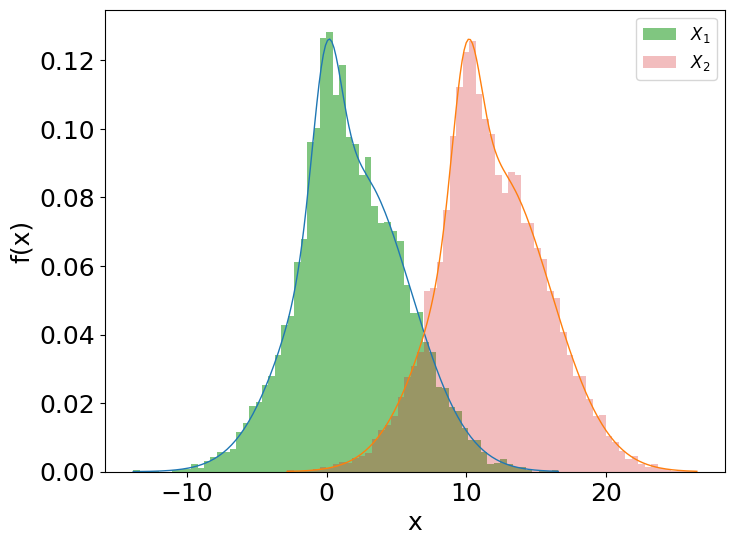

In [4]:
# Set-up.
n = 10000

xs1, ys1, y1 = sampling(n, 0.12, 0)
xs2, ys2, y2 = sampling(n, 0.12, 10)

plt.plot(xs1, ys1)
plt.plot(xs2, ys2)
plt.hist(y1, bins="fd", density=True, label='$X_1$', alpha = 0.6)
plt.hist(y2, bins="fd", density=True, label='$X_2$', alpha = 0.3)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(loc='best')
plt.show()


In [5]:
#лекция 3, 28:29
#семинар 2 39:09 - мощность
#семинар 3 1:05:55 - st.wilcoxon

##Про критерий
Т.к. выборки у нас не связанные, мы должны воспользоваться одновыборочным критерием знаковых рангов Уилкоксона (`stats.wilcoxon`) для выборки $X = X_2 - X_2$ (иначе мы бы могли рассматривать двухвыборочный критерий знаковых рангов для связанных выборок). Тогда наша гипотеза $H_0$ против альтернативы $H_1$ выглядят следующим образом:
$$H_0: \text{med}X = 0 \\
H_1: \text{med}X <\neq> 0$$
Стоит упомянуть, что для данного критерий предполагается, что выборка симметрична относительно медианы. Посмотрим на нашу выборку


(array([  2.,   0.,   1.,   1.,   2.,   6.,   4.,  16.,   7.,  23.,  18.,
         35.,  42.,  47.,  61.,  86.,  78., 133., 147., 181., 211., 227.,
        252., 301., 315., 364., 415., 428., 492., 486., 487., 495., 517.,
        497., 458., 401., 393., 344., 291., 291., 253., 225., 196., 175.,
        121., 107.,  92.,  57.,  57.,  43.,  33.,  20.,  26.,  13.,   9.,
         12.,   1.,   3.,   0.,   1.,   0.,   0.,   1.]),
 array([-10.38593244,  -9.73201202,  -9.07809161,  -8.42417119,
         -7.77025078,  -7.11633036,  -6.46240994,  -5.80848953,
         -5.15456911,  -4.50064869,  -3.84672828,  -3.19280786,
         -2.53888745,  -1.88496703,  -1.23104661,  -0.5771262 ,
          0.07679422,   0.73071464,   1.38463505,   2.03855547,
          2.69247588,   3.3463963 ,   4.00031672,   4.65423713,
          5.30815755,   5.96207797,   6.61599838,   7.2699188 ,
          7.92383921,   8.57775963,   9.23168005,   9.88560046,
         10.53952088,  11.19344129,  11.84736171,  12.501282

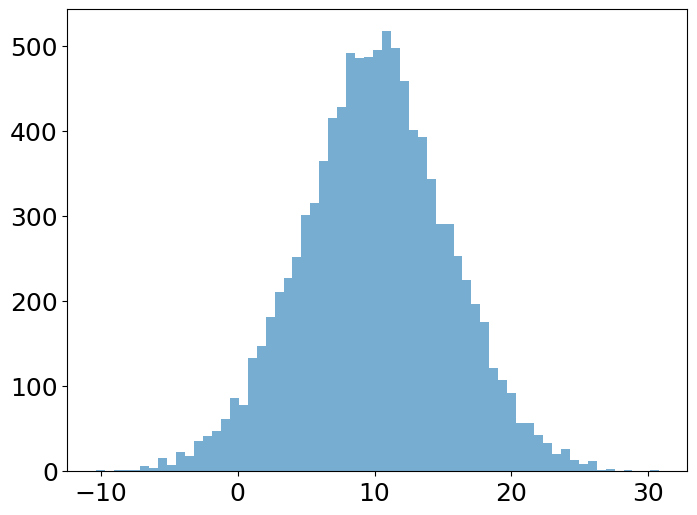

In [6]:
plt.hist(y2-y1, bins="fd", label='$X$', alpha = 0.6)

С учетом, что мы демонстрируем для выборок со смещением $\delta = 10$, можно проследить симметричность относительно $med = 10$

##Мощность `pow`
Вспомним, что такое мощность критерия
$$pow =\mathbb{P}(H_1|H_1)$$
т.е. это вероятность отвергнуть нулевую гипотезу при истинности $H_1$.
На практике мы будем замерять мощность следующим образом: для зафиксированных $\alpha$ и $\delta$ будем $N$ раз выполнять следующи

0.   Фиксируем $\alpha$ и $\delta$
1.   Семплируем пару выборок $x_1$ и $X_2$. Далее их разность $X = X_2-X_1$ пускаем тест Уилкоксона и в случае отверения $H_0$ (`stats.wilcoxon(X) <= 0.05`) добавляем единицу к числу успехов `success`
2.  Повторяем пункт 1. $N$ раз
3.  Считаем $pow = \dfrac{success}{N}$
4. Пункты 0.-3. повторяем для разных $\alpha$ и $\delta$
Т.е наша мощность как раз считается как отношение числа отвергнутых ко всем 
Нетрудно догадаться, что медиана выборки $X$ равна $\delta$, поэтому для наглядности начнем с измерения мощности в зависимости от $\delta$


In [7]:
xs1, ys1, y1 = sampling(n, 0.12, 0)
xs2, ys2, y2 = sampling(n, 0.12, 0)
ss.wilcoxon(y2-y1)[1]

0.27302977979360477

In [8]:
def pow_delta(Delta, N, alpha, n):
  X=[]
  Y=[]
  for delta in np.arange(-Delta, Delta, 0.1):
    success = 0
    for _ in range(N):
      xs1, ys1, y1 = sampling(n, alpha, 0)
      xs2, ys2, y2 = sampling(n, alpha, delta)
      if ss.wilcoxon(y2-y1)[1]<=0.05:
        success +=1
    print('delta = ', delta)
    X.append(delta)
    Y.append(success/N)
    clear_output(True)
    plt.plot(X, Y)
    plt.xlabel("delta")
    plt.ylabel("pow")
    plt.legend(loc='best')
    plt.show()
  return X, Y    

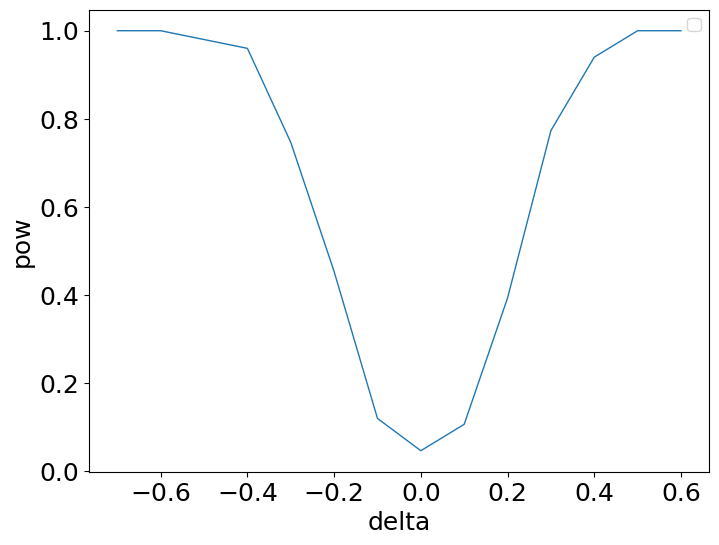

In [9]:
alpha = 0.12 #зафиксировали для примера такой alpha
n = 2500
N = 150
Delta = 0.7
delta, pow = pow_delta(Delta, N, alpha, n)
#print(pow)
# plt.plot(delta, pow)
# plt.xlabel("delta")
# plt.ylabel("pow")
# plt.legend(loc='best')
# plt.show()

Тест консервативен, если его фактический уровень значимости меньше декларируемого, т.е. если при истинности $H_0$ мы получим, что ошибка первого рода у нас меньше, чем $\alpha = 0.05$, то наш тест консервативен

In [10]:
def type_errors(N, alpha, delta):
  success = 0
  for _ in range(N):
    xs1, ys1, y1 = sampling(n, alpha, 0)
    xs2, ys2, y2 = sampling(n, alpha, 0)
    if ss.wilcoxon(y2-y1)[1]<=0.05:
        success +=1
  return success/N

In [11]:
a_pr = type_errors(50, 0.12, 0)
print("alpha_pr = ", a_pr)
if a_pr <= 0.05:
  print("Тест консервативен")
else:
  print("Тест неконсервативен")

alpha_pr =  0.12
Тест неконсервативен
